# Graph Vizualizations for the traveling TSP salesman problem

Import errtang

In [1]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
%matplotlib inline
from src.tsp_instance import TSP
from src.initialization import Initialization
from src.parent_selection import Parent_Selection
from src.recombination import Recombination
from src.mutation import Mutation
from src.evaluation import Evaluation
from src.survivor_selection import Survivor_Selection
from src.termination import Termination
from src.animation import Animation
from src.utils import *
from src.utils import debug_print as print
from src.file_utils import parse_file as parse
from src.preprocessing import precalculate_distances

IMGDIR = "./images/"

x_large_data  = "./data/TSP_Italy_16862.txt"
big_data      = "./data/TSP_Canada_4663.txt"
middle_data   = "./data/TSP_Uruguay_734.txt"
small_data    = "./data/TSP_WesternSahara_29.txt"

Set a comfortable default

In [2]:
POP_SIZE          = 100
CROSSOVER_RATE    = 0.5
NUM_GENERATIONS   = 2000
TIME_LIMIT        = 10000
MUTATION_RATE     = .2
INIT_METHOD = "random_permutations"
SELECT_METHOD = "roulette_wheel"
CROSSOVER_METHOD = "order_crossover"
MUTATION_METHOD = "flip"
EVALUATION_METHOD = "cached_euclidean"
SURVIVOR_METHOD = "mu_plus_lambda"
TERMINATOR_METHOD = "num_iterations"
DATA              = parse(middle_data)
def reset_params():
    global POP_SIZE
    global CROSSOVER_RATE
    global NUM_GENERATIONS
    global TIME_LIMIT
    global MUTATION_RATE
    global CROSSOVER_METHOD
    global MUTATION_METHOD
    POP_SIZE          = 100
    CROSSOVER_RATE    = 0.5
    NUM_GENERATIONS   = 2000
    TIME_LIMIT        = 10000
    MUTATION_RATE     = .2
    CROSSOVER_METHOD = "order_crossover"
    MUTATION_METHOD = "flip"

Same test suite as the presentation

In [3]:
def test_tsp():
    # create all modules and problem instance
    tsp = TSP(
        graph           = DATA,
        population_size = POP_SIZE,
        crossover_rate  = CROSSOVER_RATE,
        mutation_rate   = MUTATION_RATE,
        num_generations = NUM_GENERATIONS)
    initializer         = Initialization(tsp, INIT_METHOD)
    parent_selector     = Parent_Selection(tsp, SELECT_METHOD)
    mutator             = Mutation(tsp, MUTATION_METHOD)
    evaluator           = Evaluation(tsp, EVALUATION_METHOD)
    recombinator        = Recombination(tsp, CROSSOVER_METHOD, evaluator)
    survivor_selector   = Survivor_Selection(tsp, SURVIVOR_METHOD)
    terminator          = Termination(NUM_GENERATIONS, TIME_LIMIT, TERMINATOR_METHOD)
    # initialize population and perform initial evaluation
    clear_times()
    start_timer("setup")
    initializer.initialize()
    evaluator.evaluate()
    start_timer("setup")
    current_time = 0
    while terminator.method(tsp.current_generation, current_time):
    # select parents and spawn children
        parent_selector.select()
        recombinator.recombine()
        # mutate population and children
        mutator.mutate_population()
        mutator.mutate_children()
        # re-evaluate children and population
        evaluator.evaluate(use_mask=True)
        evaluator.evaluate_children()
        # select from parents and children to form new population
        survivor_selector.select()
        # add history and print debugs every 10%
        tsp.add_history("mean_fitness",tsp.fitness.mean())
        tsp.add_history("best_fitness",tsp.fitness.max())
        std = tsp.fitness.std()
        tsp.add_history("std_dev",std)
        tsp.current_generation +=1
        if not (tsp.current_generation % (tsp.num_generations // 200)):
            tsp.add_history("best_individual", tsp.population[np.argmax(tsp.fitness.max())])
            tsp.add_history("ani_fitness", tsp.fitness.max())
            tsp.add_history("ani_generation", tsp.current_generation)
            
    # print("Best Member of Population:\n", tsp.population[np.argmax(tsp.fitness)])
    tsp.add_history("times",get_times())
    return tsp

Slightly modified plot method. Takes in a dict of {names : tsp_instance objects} and plots all the instances on the same plot for comparison

There are two plot methods, inline (which displays all 3 plots horizontally) and one which simply saves each plot to a seperate file.
Yeah they could probably be combined.

In [4]:
from IPython.display import display, Markdown
def plot_tsps_inline(tsps, scale=1, title=None, file_name=None):
    fig = plt.figure(figsize=(25*scale,25*scale))    
    plt.subplot(3, 3, 1)
    plt.title("Mean Fitness", size=20*scale)
    for name, tsp in tsps.items():
        plt.plot(tsp.history["mean_fitness"], label=name)
    plt.legend()
        

    plt.subplot(3, 3, 2)
    plt.title("Best Fitness", size=20*scale)
    for name, tsp in tsps.items():
        plt.plot(tsp.history["best_fitness"], label = name)
    plt.legend()

    plt.subplot(3, 3, 3)
    plt.title("Fitness Standard Deviation", size=20*scale)
    for name, tsp in tsps.items():
        plt.plot(tsp.history["std_dev"], label = name)
        plt.legend()
    plt.subplots_adjust(wspace = .3)
    if title is not None:
        t = Markdown('<font style="font-size: 28px"><center>{}</font><br/>'.format(title))
        display(t)
    if file_name is not None:
        plt.savefig(IMGDIR + file_name + ".png", bbox_inches='tight')
    plt.legend()
    plt.show()

In [5]:
def plot_tsps(tsps, scale=1, title=None, file_name=None):
    plt.figure(figsize=(10*scale,10*scale))
    plt.title("Mean Fitness", size=20*scale)
    for name, tsp in tsps.items():
        plt.plot(tsp.history["mean_fitness"], label=name)
    plt.legend()
    if file_name is not None:
        plt.savefig(IMGDIR + file_name + "-meanFit.png", bbox_inches='tight')
    plt.show()        

    plt.figure(figsize=(10*scale,10*scale))
    plt.title("Best Fitness", size=20*scale)
    for name, tsp in tsps.items():
        plt.plot(tsp.history["best_fitness"], label = name)
    plt.legend()
    plt.savefig(IMGDIR + file_name + "-bestFit.png", bbox_inches='tight')
    plt.show()

    plt.figure(figsize=(10*scale,10*scale))
    plt.title("Fitness Standard Deviation", size=20*scale)
    for name, tsp in tsps.items():
        plt.plot(tsp.history["std_dev"], label = name)
        plt.legend()
    if title is not None:
        t = Markdown('<font style="font-size: 28px"><center>{}</font><br/>'.format(title))
        display(t)
    plt.legend()
    if file_name is not None:
        plt.savefig(IMGDIR + file_name + "-std.png", bbox_inches='tight')
    plt.show()

List of string names of different methods

In [6]:
crossover_methods = ["order_crossover", "pmx", "scx"]
mutation_methods = ["swap","flip","scramble"]

## Compare Methods

Mutations

In [7]:
reset_params()
mutation_results = {}
set_debug(False) # stop the methods from printing out
for method in mutation_methods:
    MUTATION_METHOD = method #change method
    mutation_results[method] = test_tsp() # return a tsp_instance object so we can access it's history
set_debug(True)

/moustafa/MUN Study/COMP/COMP 3201/Project/DRD4-7R/src/parent_selection.py:44: RuntimeWarning: invalid value encountered in true_divide
  selectionProbability = windowedFitness/windowedFitness.sum() #FPS
/moustafa/MUN Study/COMP/COMP 3201/Project/DRD4-7R/src/parent_selection.py:47: RuntimeWarning: invalid value encountered in less
  selectedParents = np.random.choice(popSize, size=self.tsp.num_parents-1, replace=True, p=selectionProbability)


Plot inline and seperate, saving all to files

<font style="font-size: 28px"><center>Mutation Methods Compared</font><br/>

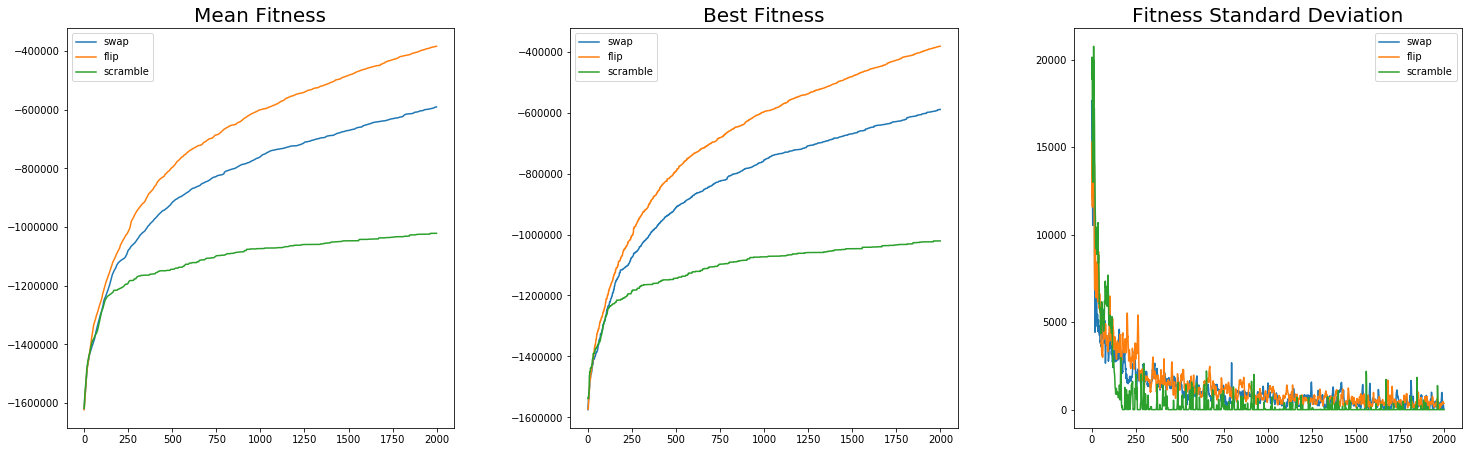

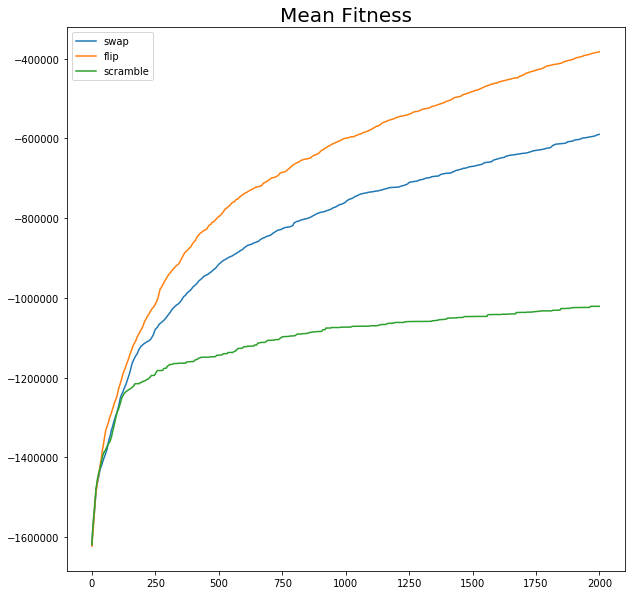

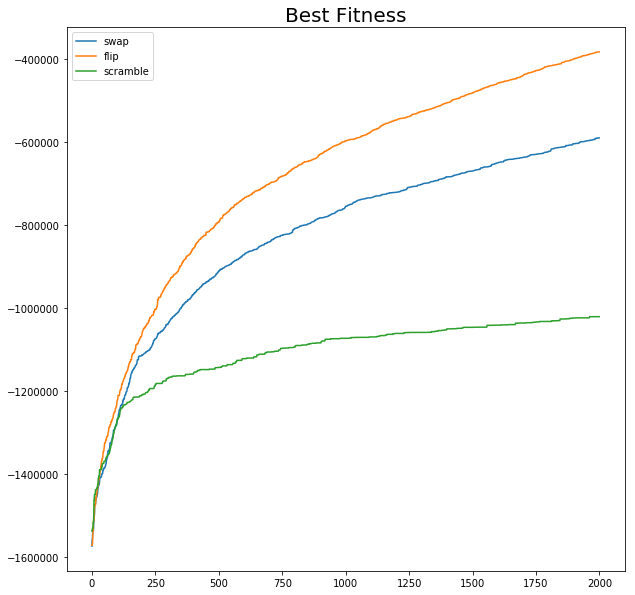

<font style="font-size: 28px"><center>Mutation Methods Compared</font><br/>

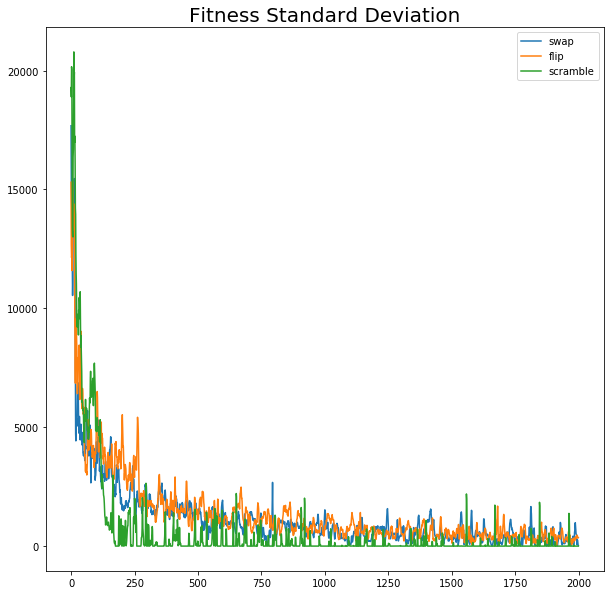

In [8]:
plot_tsps_inline(mutation_results, title="Mutation Methods Compared", file_name="mutation_methods")
plot_tsps(mutation_results, title="Mutation Methods Compared", file_name="mutation_methods")

Crossovers
(currently not working because of changes made to the archetecture for xover methods for numba. please hold)

/moustafa/MUN Study/COMP/COMP 3201/Project/DRD4-7R/src/parent_selection.py:44: RuntimeWarning: invalid value encountered in true_divide
  selectionProbability = windowedFitness/windowedFitness.sum() #FPS
/moustafa/MUN Study/COMP/COMP 3201/Project/DRD4-7R/src/parent_selection.py:47: RuntimeWarning: invalid value encountered in less
  selectedParents = np.random.choice(popSize, size=self.tsp.num_parents-1, replace=True, p=selectionProbability)


<font style="font-size: 28px"><center>Crossover Methods Compared</font><br/>

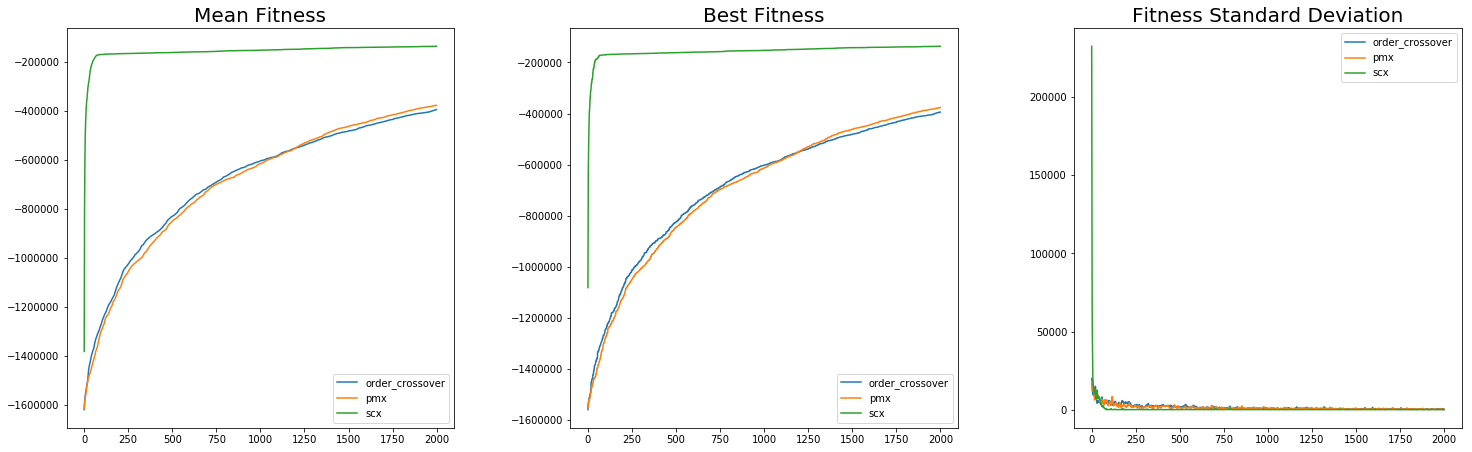

In [9]:
reset_params()
crossover_results = {}
set_debug(False) # stop the methods from printing out
for method in crossover_methods:
    CROSSOVER_METHOD = method
    crossover_results[method] = test_tsp()
set_debug(True)
plot_tsps_inline(crossover_results, title="Crossover Methods Compared", file_name="crossover_methods")